# Markup Test

In [1]:
%matplotlib inline
import pandas as pd
from analysis import plot_lin_reg
from runtimestamp.runtimestamp import runtimestamp
runtimestamp()

Updated 2023-08-07 23:38:36.358376
By leon
Using Python 3.7.3
On Darwin-22.3.0-x86_64-i386-64bit


### 1. You've filed a public records request with the agency for the risk scores and associated demographic data. They have responded with the first file, data.pdf. I'd like you to write out a plan for extracting this data for your analysis.

Because I cannot copy and parse the table as a string in Python, I would try to find open source software to automate data extraction. I would first try projects I am familiar with, such as [Tabula](https://github.com/tabulapdf/tabula). If Tabula and other projects did not work, I would reach out to data professionals in my network that may have encountered a similar problem. I would also search pypi.org and stackoverflow for Python packages that mention "PDF extraction". If I could not find an existing package to automate data extraction, I would consider writing custom software or paying for a transcriber to do the job.

### 2. You've succeeded in getting the underlying data from the PDF. Now you have the next two files: scores.csv and demographics.csv. I would like you to join the two files by the id field in each so you can continue your analysis. You should end up with a combined CSV with columns for id, score, white, minority and median_income.

To merge the data, I read the two CSVs extracted from the PDF into two Pandas dataframes.

In [2]:
demographics_input = 'data_in/demographics.csv'
scores_input = 'data_in/scores.csv'
demographics_output = 'data_out/demographics.csv'

In [3]:
demographics = pd.read_csv(demographics_input)
scores = pd.read_csv(scores_input)

From here I perform a database-style inner join operation using Pandas' `merge` function on the shared `id` column.

In [4]:
df = demographics.merge(scores, on='id')
df.head(2)

,id,minority,white,median_income,score
0,1,2.542035,4.105103,3.488905,3.339618
1,2,2.413281,3.638228,5.143353,2.254886


Looking back at the original PDF, the output of the join does not match the original data. This is a byproduct of the two input files and not of the join operation. I would double-check the data extraction and pre-processing methods.

I like to get an overview of the joined data:

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1000.0,500.5,288.819436,1.000000,250.750000,500.500000,750.250000,1000.000000
minority,1000.0,3.0,1.000000,-0.758806,2.321121,2.979640,3.674928,6.368509
white,1000.0,3.0,1.000000,-0.250220,2.347812,3.004937,3.711201,6.727476
median_income,1000.0,3.0,1.000000,0.037966,2.316184,3.010394,3.668198,6.737569
score,1000.0,4.5,2.012461,-3.349749,3.142397,4.475892,5.816223,11.469915


The `minority`, `white`, and `median_income` values all have a mean of 3 and a standard deviation of 1.

I save that output as a CSV here: `data_out/demographics.csv`.

In [10]:
df.to_csv(demographics_output, index=False)

### 3a. Use the data in demographics.csv to run a linear regression or a series of regressions to see if your hypothesis that the the score is biased is correct. You should compare the score field with some combination of the white, minority and median_income fields.

In [11]:
df = pd.read_csv(demographics_output)
df.head(2)

,id,minority,white,median_income,score
0,1,2.542035,4.105103,3.488905,3.339618
1,2,2.413281,3.638228,5.143353,2.254886


I use `Scikit-Learn`'s [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class to fit single and multivariate ordinary least squares linear regressions. Linear regression is performed in the `plot_lin_reg` function which is stored in `analysis.py`. In addition to fitting a linear regression and calculating coefficients, `plot_lin_reg` produces scatter plots with the fitted linear regression (residual plots) for single variable linear regressions. Below I iterate through each variable in the demographics output, and fit a linear regression.

/Users/leon/code/lede/algorithms/regression/analysis.py:70: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  ax1.set_facecolor(CB)


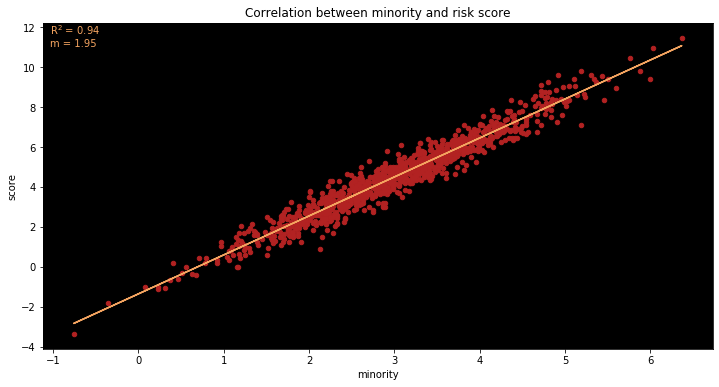

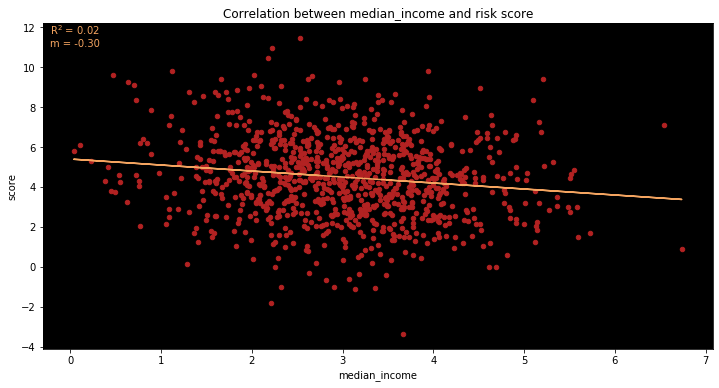

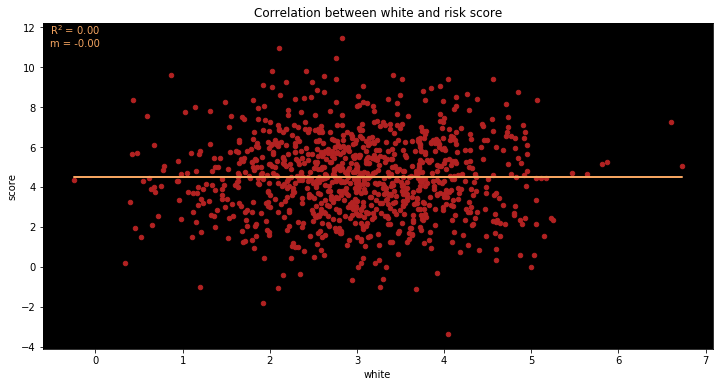

In [12]:
for variable in ['minority', 'median_income', 'white']:
    plot_lin_reg(df, variable=variable, target='score')

Looking at R<sup>2</sup> of each variable, the risk score is most strongly correlated to `minority` (R<sup>2</sup> = 0.94). There is no correlation between the risk score and `white`, and a small correlation between the risk score and `median_income` (R<sup>2</sup>=0.02).

When I perform multivariable regression using `minority` and `median_income` to predict the risk score, the R<sup>2</sup> is 1.0.

In [13]:
plot_lin_reg(df, variable=['minority', 'median_income'], target='score')

1.0


### 3b. Write a paragraph discussing what the results of your analysis would mean for the agency using the score.

From the analysis of 1000 example applicants, the risk score is derived from the `minority` and `median_income` values. 

The risk `score` is heavily tied to the `minority` score (R<sup>2</sup> = 0.94). This relationship is a positive correlation: the risk `score` increases with an increasing `minority` score. Median income also plays a role and exhibits a negative correlation: the risk `score` decreases with an increasing `median_income` (R<sup>2</sup> = 0.02). This suggests that the government agency's risk model is biased because it assigns a higher risk score to applicants with a lower median income and a higher minority score. Because the government agency assigns public resources to lower scored areas, it will reward non-minority, higher earning communities.

Taking a step back, I am skeptical of anything that resembles a minority score. It implies such a feature can be quantified and placed on a continuous spectrum.

### 3c. You recieve documentation from a FOIA that provides a hierarchy for risk scores. Score above 6 are considered "high risk." With this in mind, create a new boolean column called `is_high_risk` and run a logistic regression and interpret the results

In [14]:
import statsmodels.formula.api as smf
import numpy as np

In [15]:
df['is_high_risk'] = df['score'].apply(lambda x: 1 if x>6 else 0)

In [16]:
df['is_high_risk']

0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    0
997    0
998    0
999    0
Name: is_high_risk, Length: 1000, dtype: int64

In [31]:
formula = "is_high_risk ~ minority"

In [32]:
results = smf.logit(formula=formula, data=df).fit(disp=0)


In [33]:
table = pd.DataFrame({
    'variables': results.params.keys(),
    'coef': results.params.values,
    'odds_ratio': np.exp(results.params.values),
    
})

In [34]:
table

,variables,coef,odds_ratio
0,Intercept,-28.186155,5.739957e-13
1,minority,7.481527,1.774949e+03


In [35]:
results.prsquared

0.7620572387901444